In [3]:
%run 'import_dbase.ipynb'
%run 'import_plots.ipynb'

In [4]:
# v1 heater 1 csv
# v4 heater 2 csv
# v5 line
# v8 fan csv

def tableName(run='004'):

    cursor = connectDbase('rct007')

    tbName0 = 'rct007_testID'
    tbName1 = run+'_flowindata'
    tbName2 = run+'_flowoutdata'
    tbName3 = run+'_plcdata'
    tbName4 = run+'_voltagedata'
    tbName5 = run+'_logdata'
    return [tbName0, tbName1, tbName2, tbName3, tbName4, tbName5]


def findPower(cvs, line):
    senseR = 2.
    voltD = 23.
    ph1 = (cvs/senseR) * (line*voltD)
    mph1 = np.mean(ph1)
    sph1 = np.std(ph1)
    return mph1, sph1

def findInputPower(volt):
    [mheater1,sheater1] = findPower(volt.v1, volt.v5)
    [mheater2,sheater2] = findPower(volt.v4, volt.v5)
    [mfan,sfan] = findPower(volt.v8, volt.v5)
    inputPower =  mheater1 + mheater2 + mfan
    return inputPower

def readVolt(start, end):
    a = '''
    SELECT *
    FROM %s ''' 

    b = '''
    WHERE date between \'%s\' AND \'%s\'
    '''%(start, end)
    rmsQuery = a+b
    volt = readTable(cursor, t4, rmsQuery)
    return volt

def parseLog(cursor, run):
    log = readNoDateTable(cursor, run+'_logdata')
    stateStart = log[log.state=='1'].date
    stateEnd = log[log.state=='0'].date
    return stateStart, stateEnd

def inputPowerVect(start, end):
    out = []
    for ii,s in enumerate(start):
        volt = readVolt(s,pd.to_datetime(end.values[ii]))
        out.append(findInputPower(volt))
    return out    

def rtdStats(rtd, amb, s, e):
    rtdMean = rtd.mean().mean()
    rtdStd = rtd.std().mean()
    boxMean = amb[['amb_rtd3','amb_rtd4']].mean().mean()
    ceilMean = amb[['amb_rtd1','amb_rtd2']].mean().mean()
    return rtdMean, rtdStd, boxMean, ceilMean

def rtdVect(cursor, t3, start, end):
    outM = []
    outS = []
    outB = []
    outC = []
    for ii,s in enumerate(start):
        
        plc = readDateTable(cursor, t3, s, pd.to_datetime(end.values[ii]))
        rct = plc[['rct_rtd1', 'rct_rtd2', 'rct_rtd3', 'rct_rtd4', 'rct_rtd5', 'rct_rtd6']]
        amb = plc[['amb_rtd1','amb_rtd2','amb_rtd3','amb_rtd4']]
  
        
        [rm, rs, bm, cm] = rtdStats(rct, amb, s,pd.to_datetime(end.values[ii]))
        outM.append(rm)
        outS.append(rs)
        outB.append(bm)
        outC.append(cm)
    return outM, outS, outB, outC

def flowStats(table, col, start, end):
    fi = readDateTable(cursor, table, start, end)
    pulseInDelta = fi.ix[-1,col] - fi.ix[0,col]
    dt = (fi.date[-1] - fi.date[0])
    print fi.date[0], fi.date[-1]
    dts = dt.seconds
    A=fi.iloc[:,1]-fi.iloc[0,1]
    dateA = np.diff(fi.iloc[:,0]-fi.iloc[0,0])/np.timedelta64(1, 's')
    fistd = np.std(np.diff(A)/dateA)
    return pulseInDelta, fistd, dts


def density(temp):
    Density = (1.626*(10**-5)*temp**3-6.021*(10**-3)*temp**2+0.021*temp + 1000.066)/1000
    return Density

def specificHeat(temp):
    SH = -3.588*(10**-11)*(temp**5)+1.212*(10**-8)*(temp**4)-1.564*(10**-6)*(temp**3)+1.036*(10**-4)*(temp**2)-3.266*(10**-3)*temp + 4.216
    return SH

def heatOutput(pulseOutDelta, pulseInDelta, flowInTemp, flowOutTemp, sampleTime):
    
    deltaT = flowOutTemp - flowInTemp
    Germanflowmetercalibration = 1860.

    #liter per min, there is error as OUT is greater than IN
    FLOWINVOLUME = pulseInDelta / Germanflowmetercalibration / sampleTime
    FLOWOUTVOLUME = pulseOutDelta / Germanflowmetercalibration / sampleTime
    #Mass flow rate - kg/sec
    Massflowin = FLOWINVOLUME * density(flowInTemp)
    Massflowout = FLOWOUTVOLUME * density(flowOutTemp)

    #Multiplying to get Q (mcdT) J/sec [W]
    Qin = (Massflowin * specificHeat(flowInTemp) * deltaT)*1000.
    Qout = (Massflowout * specificHeat(flowOutTemp) * deltaT)*1000.
    Qfinal = (Qin+Qout)/2.

    return Qfinal

def heatCalc(pulseDelta, flowTemp, deltaTemp, timeInteraval):
    
    germanFlowMeterCalibration = 1860.

    #liter per min, there is error as OUT is greater than IN
    volumeFlow = pulseDelta / germanFlowMeterCalibration / timeInteraval
    
    #Mass flow rate - kg/sec
    massFlow = volumeFlow * density(flowTemp)

    #Multiplying to get Q (mcdT) J/sec [W]
    Q = (massFlow * specificHeat(flowTemp) * deltaTemp)*1000.
    
    return Q


In [5]:
def flowVect(cursor, tin, tout, t3, start, end):
    fiPulse = []
    foPulse = []
    fiStd = []
    foStd = []
    heatOut = []
    for ii,s in enumerate(start):
        plc = readDateTable(cursor, t3, s, pd.to_datetime(end.values[ii]))
        flow = plc[['flowin_rtd','flowout_rtd']]
        ftmean = flow.mean()
        deltaTemp = ftmean[1] - ftmean[0]
        
        [fip, fis, dtsi] = flowStats(tin, 'flowin', s, pd.to_datetime(end.values[ii]))
        [fop, fos, dtso] = flowStats(tout, 'flowout', s, pd.to_datetime(end.values[ii]))

        #heatOutOne = heatOutput(fop, fip, ftmean[0], ftmean[1], dtsi)
        Qin  = heatCalc(fip, ftmean[0], deltaTemp, dtsi)
        Qout = heatCalc(fop, ftmean[1], deltaTemp, dtso)
        Qfinal = (Qin+Qout)/2.
        print Qin, Qout
        
        fiPulse.append(fip)
        fiStd.append(fis)
        foPulse.append(fop)
        foStd.append(fos)
        heatOut.append(Qfinal)
        
    return fiPulse, fiStd, foPulse, foStd, heatOut

In [ ]:
def makePickle(cursor, t1, t2, t3, t4, t5, run, start, end):

    for ii,s in enumerate(start):
        
        plc = readDateTable(cursor, t3, s, pd.to_datetime(end.values[ii]))
        volt = readDateTable(cursor, t4, s, pd.to_datetime(end.values[ii]))
        fin = readDateTable(cursor, t1, s, pd.to_datetime(end.values[ii]))
        fout = readDateTable(cursor, t2, s, pd.to_datetime(end.values[ii]))
        plc.to_pickle(run+'_plc'+str(ii)+'.pkl')
        volt.to_pickle(run+'_volt'+str(ii)+'.pkl')
        fin.to_pickle(run+'_fin'+str(ii)+'.pkl')
        fout.to_pickle(run+'_fout'+str(ii)+'.pkl')
        


In [ ]:
#makePickle(cursor, t1,t2,t3,t4,t5, '004', start, end)

In [6]:
cursor = connectDbase('rct007')
[t0,t1,t2,t3,t4,t5] = tableName('004')
[start, end] = parseLog(cursor, '004')
numRuns = np.min([len(start), len(end)])
start = start[0:numRuns]
end = end[0:numRuns]



#rtdOut = rtdVect(cursor, t3, start, end)

#flowOut = flowVect(cursor, t1, t2, t3, start, end)

powerIn = inputPowerVect(start,end)


In [10]:
flowout = flowVect(cursor, t1, t2, t3, start, end)
powerOut = flowOut[-1]

2016-06-28 00:46:39.521451 2016-06-28 01:16:41.223184
2016-06-28 00:46:39.542835 2016-06-28 01:16:41.252470
27.0766923726 25.6685505691
2016-06-28 02:46:47.828632 2016-06-28 03:16:49.780359
2016-06-28 02:46:47.876726 2016-06-28 03:16:49.595323
45.9009443179 42.8273135583
2016-06-28 04:46:56.407836 2016-06-28 05:16:58.359552
2016-06-28 04:46:56.480494 2016-06-28 05:16:58.179514
66.8437408586 60.849060773
2016-06-28 07:07:06.506319 2016-06-28 07:23:07.999957
2016-06-28 07:07:06.566686 2016-06-28 07:37:08.516123
99.548512805 91.4494919628
2016-06-28 09:17:16.115077 2016-06-28 09:47:17.569561
2016-06-28 09:17:16.051782 2016-06-28 09:47:17.764863
171.869732665 159.627103059
2016-06-28 11:57:27.285580 2016-06-28 12:27:29.239298
2016-06-28 11:57:27.257353 2016-06-28 12:27:29.470464
239.258293598 221.836800614
2016-06-28 15:07:41.457138 2016-06-28 15:37:43.410284
2016-06-28 15:07:41.459587 2016-06-28 15:37:43.415671
25.7246306486 24.3540658234
2016-06-28 15:50:06.599175 2016-06-28 16:20:08.552

NameError: name 'flowOut' is not defined

ValueError: x and y must be the same size

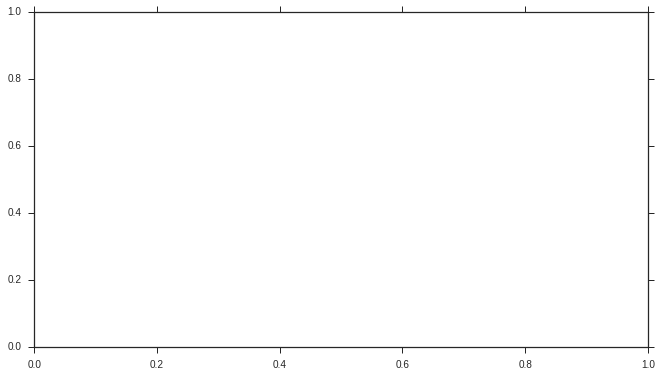

In [11]:
%matplotlib inline

# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    
    
    
sns.set_style("white")
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(11, 6))
ax.scatter(powerIn, powerOut)
plt.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5)
plt.grid(axis='x',color='grey', linestyle='--', lw=0.5, alpha=0.5)
sns.despine(trim=True, left=True, bottom=True)
ax = sns.regplot(x=np.array(powerIn), y=np.array(powerOut), ci=99, line_kws={'lw': 2}, color=tableau20[6])
plt.xlabel('\nPower In $(W)$', fontsize=18)
plt.ylabel('\nPower Out $(W)$', fontsize=18)
# plt.xlabel('')
# plt.ylabel('')


In [12]:
powerIn

[10.179570928684162,
 30.269903106829048,
 50.10246526832036,
 88.59499210652525,
 160.90464553529597,
 238.06109159361824,
 10.149050569976085,
 10.195500758841966,
 30.21798246988464,
 49.68567004033269,
 88.52863523229773,
 161.302274429694,
 239.98384852838345,
 10.166825988491945,
 10.158894998325755,
 27.974013632342768,
 49.279044191846666,
 87.24139563481295,
 161.2280781804269,
 241.11515107224236,
 10.250341260078816,
 10.196757425194384,
 30.3607686423665,
 50.01776256930175,
 88.6681732250411,
 160.37233148096354,
 238.0951418293374,
 10.034421736624523,
 10.131091260544995,
 30.287510354362276,
 50.084475475442126,
 88.78243138258432,
 161.66738994293834,
 240.5442712843875,
 10.202930559746957,
 10.135064462899747,
 30.0903866778603,
 49.686336859325046,
 87.75388173735648,
 160.90556377361128,
 240.40888780431757,
 10.285588090946082,
 10.289286396605904,
 30.428382236197173,
 50.297400216350596,
 88.99953372508548,
 161.6580703315824,
 240.18267243180134]